## Install  Kaggle First to Get the Datasets


In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()  # This will prompt you to upload the 'kaggle.json' file


Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"mhdzikoo","key":"36008383d397cefb36eebe7cd0986d31"}'}

In [ ]:
import os
os.makedirs("/root/.kaggle", exist_ok=True)
os.rename("kaggle.json", "/root/.kaggle/kaggle.json")


In [ ]:
!kaggle competitions download -c invasive-species-monitoring


100% 3.11G/3.12G [00:40<00:00, 107MB/s]
100% 3.12G/3.12G [00:40<00:00, 83.2MB/s]


## Unzip the Data

In [ ]:
!unzip invasive-species-monitoring.zip


Archive:  invasive-species-monitoring.zip
  inflating: sample_submission.csv.zip  
  inflating: test.7z                 
  inflating: train.7z                
  inflating: train_labels.csv.zip    


In [ ]:
!unzip train.7z


Archive:  train.7z
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of train.7z or
        train.7z.zip, and cannot find train.7z.ZIP, period.


In [ ]:
!pip install py7zr


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.3/93.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 33.6 MB/s eta 0:00:00


# Import All Dependinces

In [ ]:
import os
import pandas as pd
import json
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import mixed_precision
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import seaborn as sns



# Extract the folders

In [ ]:
import py7zr

# Define the file path
file_path = 'train.7z'
extracted_folder = ''

# Extract the file
with py7zr.SevenZipFile(file_path, mode='r') as z:
    z.extractall(path=extracted_folder)

print(f"Contents extracted to: {extracted_folder}")


Contents extracted to: 


In [ ]:
import py7zr

# Define the file path
file_path = 'test.7z'
extracted_folder2 = ''

# Extract the file
with py7zr.SevenZipFile(file_path, mode='r') as z:
    z.extractall(path=extracted_folder2)

print(f"Contents extracted to: {extracted_folder2}")


Contents extracted to: 


In [ ]:
!unzip train_labels.csv.zip


Archive:  train_labels.csv.zip
  inflating: train_labels.csv        
   creating: __MACOSX/
  inflating: __MACOSX/._train_labels.csv  


# Getting the image Data

In [ ]:
import os

# Path to the extracted folder
# extracted_folder = 'invasive-species-monitoring/train/train'
extracted_folder = 'train'

# List all files in the folder
extracted_files = os.listdir(extracted_folder)

# Filter image files based on common image extensions
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
image_files = [file for file in extracted_files if any(file.lower().endswith(ext) for ext in image_extensions)]

# Get the number of image files
num_images = len(image_files)

print(f"Number of image files: {num_images}")


Number of image files: 2295


In [ ]:
import os

# Path to the extracted folder
# extracted_folder2 = 'invasive-species-monitoring/test/test'
extracted_folder2 = 'test'

# List all files in the folder
extracted_files2 = os.listdir(extracted_folder2)

# Filter image files based on common image extensions
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
image_files2 = [file for file in extracted_files2 if any(file.lower().endswith(ext) for ext in image_extensions)]

# Get the number of image files
num_images2 = len(image_files2)

print(f"Number of image files: {num_images2}")


Number of image files: 1531


In [ ]:

# Load the CSV file
# csv_file_path = 'invasive-species-monitoring/train_labels.csv/train_labels.csv'
csv_file_path = 'train_labels.csv'

df = pd.read_csv(csv_file_path)

# Show the first few rows to verify it's loaded correctly
df.head()


,name,invasive
0,1,0
1,2,0
2,3,1
3,4,0
4,5,1


In [ ]:
pip install Pillow


In [ ]:
import os
from PIL import Image
import numpy as np

# train_folder_path = 'invasive-species-monitoring/train/train'

train_folder_path = 'train'

image_files = os.listdir(train_folder_path)

images = []
labels = []

for index, row in df.iterrows():
    image_name = f"{row['name']}.jpg"

    if image_name in image_files:

        image_path = os.path.join(train_folder_path, image_name)
        image = Image.open(image_path)
        image = image.resize((224, 224))
        image = np.array(image)


        images.append(image)
        labels.append(row['invasive'])

images = np.array(images)
labels = np.array(labels)

print(f"Loaded {len(images)} images with corresponding labels.")


Loaded 2295 images with corresponding labels.


# Split the Data

In [ ]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split  # Make sure this is imported

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

# Print the sizes of the splits
print(f"Training set: {len(X_train)} images")
print(f"Test set: {len(X_test)} images")

Training set: 1836 images
Test set: 459 images


# Normalization

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0


# Show data After Normalization

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np

# Example data: Images (X) and Labels (y)
#X_train = images  # NumPy array of images (shape: [num_samples, 224, 224, 3])
#y_train = labels  # NumPy array of labels (shape: [num_samples])
print(X_train)
print(y_train)

[[[[0.29411765 0.28627451 0.35686275]
   [0.29411765 0.29019608 0.34901961]
   [0.31372549 0.31372549 0.37647059]
   ...
   [0.68627451 0.81960784 0.79215686]
   [0.80784314 0.93333333 0.90588235]
   [0.72941176 0.85882353 0.81960784]]

  [[0.28235294 0.27058824 0.34509804]
   [0.28627451 0.28627451 0.35686275]
   [0.28627451 0.29019608 0.36862745]
   ...
   [0.6627451  0.74901961 0.74117647]
   [0.71764706 0.84705882 0.81568627]
   [0.65098039 0.79215686 0.74509804]]

  [[0.28627451 0.29411765 0.3372549 ]
   [0.29019608 0.29019608 0.34509804]
   [0.27058824 0.28235294 0.36078431]
   ...
   [0.70980392 0.75686275 0.75294118]
   [0.61960784 0.70588235 0.6745098 ]
   [0.5254902  0.61960784 0.58823529]]

  ...

  [[0.7372549  0.89803922 0.80392157]
   [0.4627451  0.54509804 0.42745098]
   [0.49411765 0.54117647 0.39607843]
   ...
   [0.44705882 0.4745098  0.31764706]
   [0.38823529 0.39607843 0.30588235]
   [0.30588235 0.29411765 0.24313725]]

  [[0.77647059 0.94509804 0.85882353]
   [0.5

In [ ]:
# Define 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store fold metrics
fold_accuracies = []


# Gpu Test

In [ ]:
import tensorflow as tf
print("Is GPU available?", tf.test.is_gpu_available())


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available? True


In [ ]:
from tensorflow.keras import backend as K
K.clear_session()

import gc
gc.collect()


660

In [ ]:
import os
import tensorflow as tf

# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available.")
    print("Available GPUs:", gpus)
else:
    print("GPU is not available.")

# Optional: Limit TensorFlow GPU memory usage (similar to PyTorch)
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Set memory growth for GPU: {gpu}")
    except RuntimeError as e:
        print(f"Could not set memory growth for GPU: {gpu}. Error: {e}")


GPU is available.
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Set memory growth for GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Limit GPU memory to 4GB (adjust as needed)
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=4096)]
        )
        print("Limited GPU memory to 4GB.")
    except RuntimeError as e:
        print(f"Error setting memory limit: {e}")


Limited GPU memory to 4GB.


# Don't Run

In [ ]:
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)


# Model Summary

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define the custom CNN model
model = Sequential()

# Layer 1: Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2: Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3: Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the layers
model.add(Flatten())

# Fully connected layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Regularization to prevent overfitting

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,245,825 (84.86 MB)

 Trainable params: 22,245,377 (84.86 MB)

 Non-trainable params: 448 (1.75 KB)

# Data Augmanted && Cross-validation tecnique

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Start cross-validation loop
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    print(f"Training Fold {fold}")

    # Split the data into training and validation sets for the current fold
    X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
    X_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]

    # Create the model for this fold or load the best model from the previous fold
    model = create_model()

    # Load the best model from the previous fold, if exists
    best_model_filepath = os.path.join(history_folder, f'fold_{fold-1}_best_model.keras')
    if fold > 1 and os.path.exists(best_model_filepath):
        print(f"Loading best model from Fold {fold - 1}")
        model = load_model(best_model_filepath)

    # Define the model checkpoint callback to save the best model based on validation accuracy
    model_checkpoint = ModelCheckpoint(
        os.path.join(history_folder, f'fold_{fold}_best_model.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    )

    # Define the early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_accuracy',  # Metric to monitor
        patience=5,  # Number of epochs with no improvement before stopping
        mode='max',  # Maximizing the metric
        verbose=1  # Print a message when stopping
    )

    # Train the model on this fold
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=50,
        batch_size=16,
        callbacks=[model_checkpoint, early_stopping],  # Include early stopping
        verbose=2  # To print detailed information (loss and accuracy) after each epoch
    )

    # Save the history to a file
    history_filepath = os.path.join(history_folder, f'fold_{fold}_history.json')
    with open(history_filepath, 'w') as f:
        json.dump(history.history, f)

    # Save the final model (in addition to the best model during training)
    model.save(os.path.join(history_folder, f'fold_{fold}_final_model.keras'))

    # Save the validation accuracy in a separate file
    val_accuracy = history.history['val_accuracy']
    val_accuracies.append(np.max(val_accuracy))  # Save the highest validation accuracy for this fold
    val_accuracy_filepath = os.path.join(history_folder, f'fold_{fold}_val_accuracy.json')
    with open(val_accuracy_filepath, 'w') as f:
        json.dump(val_accuracy, f)

    # Clear session to free up memory after each fold
    tf.keras.backend.clear_session()

# After all folds, calculate and print the average validation accuracy
average_val_accuracy = np.mean(val_accuracies)
print(f"Average Validation Accuracy across all folds: {average_val_accuracy:.4f}")

# Optionally, save the average validation accuracy to a file
average_val_accuracy_filepath = os.path.join(history_folder, 'average_val_accuracy.json')
with open(average_val_accuracy_filepath, 'w') as f:
    json.dump({'average_val_accuracy': average_val_accuracy}, f)

# After all folds, print a message
print("5-Fold Cross-Validation completed. History and models saved.")


NameError: name 'kf' is not defined

# train seperatly

In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

# Enable memory growth for GPU early in the script (before model initialization)
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except:
        pass

# Define the custom CNN model
model = Sequential()

# Layer 1: Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2: Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3: Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the layers
model.add(Flatten())

# Fully connected layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Regularization to prevent overfitting

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

# File to track completed folds
completed_folds_file = 'CNNModel.txt'

# Folder to store checkpoints and history
checkpoints_folder = 'CNNModelOnlyOne'
os.makedirs(checkpoints_folder, exist_ok=True)

# Checkpoint file for the current fold
fold_number = 1  # Update fold number as needed
checkpoint_filepath = os.path.join(checkpoints_folder, f'cnn_fold{fold_number}.keras')  # Change .h5 to .keras

# Define checkpoint callback (without 'save_format' argument)
checkpoint_callback = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Assuming you have your training data (X_train, y_train) and validation data (X_val, y_val)
# Replace X_train, y_train, X_val, y_val with your actual data
history = model.fit(
    X_train, y_train,  # Replace with actual training data
    validation_split=0.2,  # Automatically split 20% of the training data for validation
    epochs=30,
    batch_size=32,
    callbacks=[checkpoint_callback]
)
# Save history to a JSON file
history_filepath = os.path.join(checkpoints_folder, f'fold_{fold_number}_history.json')
with open(history_filepath, 'w') as f:
    json.dump(history.history, f)

# Evaluate on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Fold {fold_number} Accuracy: {val_accuracy:.4f}")

# Clear session to free up memory
tf.keras.backend.clear_session()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,245,825 (84.86 MB)

 Trainable params: 22,245,377 (84.86 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.6924 - loss: 14.5463
Epoch 1: val_loss improved from inf to 117.52757, saving model to CNNModelOnlyOne/cnn_fold1.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 46s 891ms/step - accuracy: 0.6932 - loss: 14.4558 - val_accuracy: 0.3886 - val_loss: 117.5276
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7823 - loss: 3.7234
Epoch 2: val_loss improved from 117.52757 to 11.89622, saving model to CNNModelOnlyOne/cnn_fold1.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 71s 705ms/step - accuracy: 0.7825 - loss: 3.7120 - val_accuracy: 0.3859 - val_loss: 11.8962
Epoch 3/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8544 - loss: 0.7517
Epoch 3: val_loss improved from 11.89622 to 2.28835, saving model to CNNModelOnlyOne/cnn_fold1.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 45s 793ms/step - accuracy: 0.8540 - loss: 0.7530 - val_accuracy: 0.4076 - val_loss: 2.2883
Epoch 4/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8941 - loss: 0.353

KeyboardInterrupt: 

# Plotting Training vs Validation Accuracy and Loss (Performance Curves)

Files in the checkpoints folder:
['fold_4_val_accuracy.json', 'fold_3_best_model.keras', 'fold_1_best_model.keras', 'average_val_accuracy.json', 'fold_2_history.json', 'fold_5_val_accuracy.json', 'fold_5_final_model.keras', 'fold_4_final_model.keras', 'fold_3_history.json', 'fold_3_final_model.keras', 'fold_4_history.json', 'fold_2_val_accuracy.json', 'fold_1_final_model.keras', 'fold_5_best_model.keras', 'fold_3_val_accuracy.json', 'fold_4_best_model.keras', 'fold_5_history.json', 'fold_1_history.json', 'fold_2_best_model.keras', 'fold_2_final_model.keras', 'fold_1_val_accuracy.json']
Looking for history file: CNNModelHistory/fold_3_history.json
Found history file: CNNModelHistory/fold_3_history.json
Looking for history file: CNNModelHistory/fold_1_history.json
Found history file: CNNModelHistory/fold_1_history.json
Looking for history file: CNNModelHistory/fold_5_history.json
Found history file: CNNModelHistory/fold_5_history.json
Looking for history file: CNNModelHistory/fold_4_hist

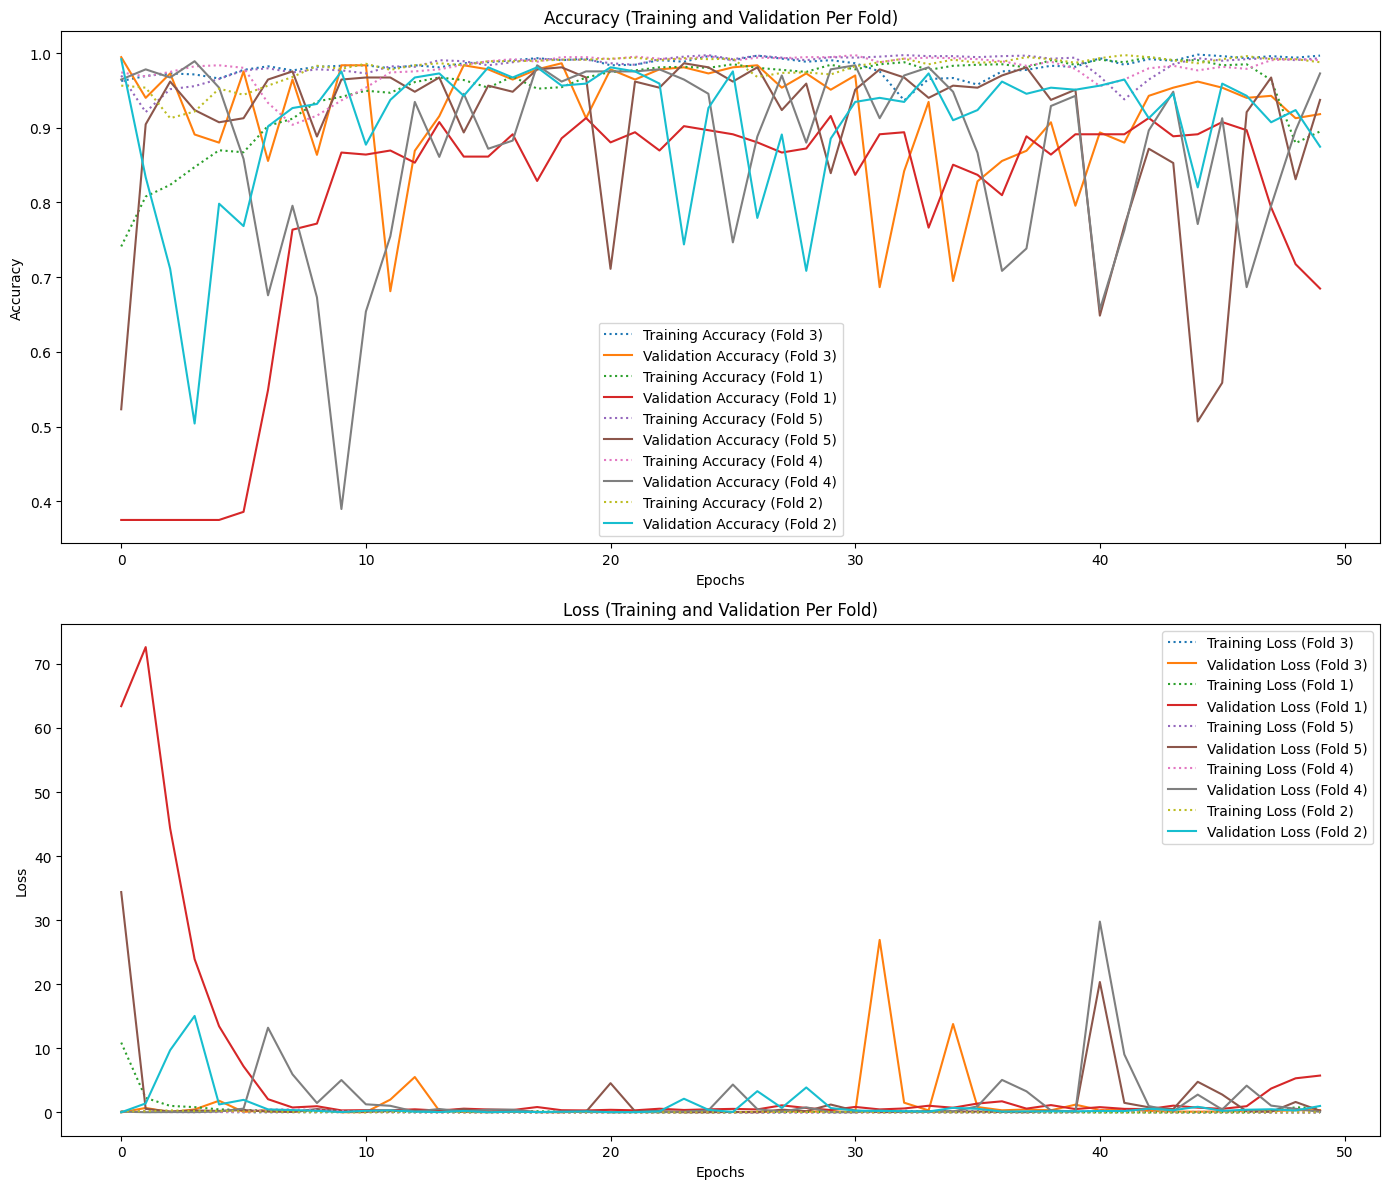

In [ ]:
import os
import matplotlib.pyplot as plt
import json

# Folder where checkpoints and history files are stored
checkpoints_folder = 'CNNModelHistory'

# List all checkpoint files (model files)
checkpoint_files = [f for f in os.listdir(checkpoints_folder) if f.endswith('.keras')]

# Dictionary to store metrics by fold
fold_metrics = {}

# Debug: List all files in the folder
print("Files in the checkpoints folder:")
print(os.listdir(checkpoints_folder))

# Load history from each fold's saved history file
for checkpoint_file in checkpoint_files:
    # Extract fold number from the .keras file name
    fold_number = checkpoint_file.split('_')[1].replace('fold', '').replace('.keras', '')

    # Define the correct history file path
    history_filepath = os.path.join(
        checkpoints_folder,
        f'fold_{fold_number}_history.json'  # Matches the actual history file naming
    )

    # Debug: Print the derived history filepath
    print(f"Looking for history file: {history_filepath}")

    # Check if history file exists
    if os.path.exists(history_filepath):
        print(f"Found history file: {history_filepath}")
        with open(history_filepath, 'r') as f:
            history = json.load(f)

        # Store metrics for this fold
        fold_metrics[fold_number] = {
            'val_accuracy': history.get('val_accuracy', []),
            'val_loss': history.get('val_loss', []),
            'train_accuracy': history.get('accuracy', []),
            'train_loss': history.get('loss', [])
        }
    else:
        print(f"History file not found for checkpoint: {checkpoint_file}")

# Debug: Check loaded data
print(f"Loaded metrics for folds: {list(fold_metrics.keys())}")

# Plot Accuracy and Loss for each fold (Validation and Training)
plt.figure(figsize=(14, 12))

# Validation and Training Accuracy
plt.subplot(2, 1, 1)
for fold, metrics in fold_metrics.items():
    plt.plot(metrics['train_accuracy'], label=f'Training Accuracy (Fold {fold})', linestyle='dotted')
    plt.plot(metrics['val_accuracy'], label=f'Validation Accuracy (Fold {fold})', linestyle='solid')
plt.title('Accuracy (Training and Validation Per Fold)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Validation and Training Loss
plt.subplot(2, 1, 2)
for fold, metrics in fold_metrics.items():
    plt.plot(metrics['train_loss'], label=f'Training Loss (Fold {fold})', linestyle='dotted')
    plt.plot(metrics['val_loss'], label=f'Validation Loss (Fold {fold})', linestyle='solid')
plt.title('Loss (Training and Validation Per Fold)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# plot seperately

Files in the checkpoints folder:
['fold_4_val_accuracy.json', 'fold_3_best_model.keras', 'fold_1_best_model.keras', 'average_val_accuracy.json', 'fold_2_history.json', 'fold_5_val_accuracy.json', 'fold_5_final_model.keras', 'fold_4_final_model.keras', 'fold_3_history.json', 'fold_3_final_model.keras', 'fold_4_history.json', 'fold_2_val_accuracy.json', 'fold_1_final_model.keras', 'fold_5_best_model.keras', 'fold_3_val_accuracy.json', 'fold_4_best_model.keras', 'fold_5_history.json', 'fold_1_history.json', 'fold_2_best_model.keras', 'fold_2_final_model.keras', 'fold_1_val_accuracy.json']
Looking for history file: CNNModelHistory/fold_1_history.json
Found history file: CNNModelHistory/fold_1_history.json
Looking for history file: CNNModelHistory/fold_1_history.json
Found history file: CNNModelHistory/fold_1_history.json


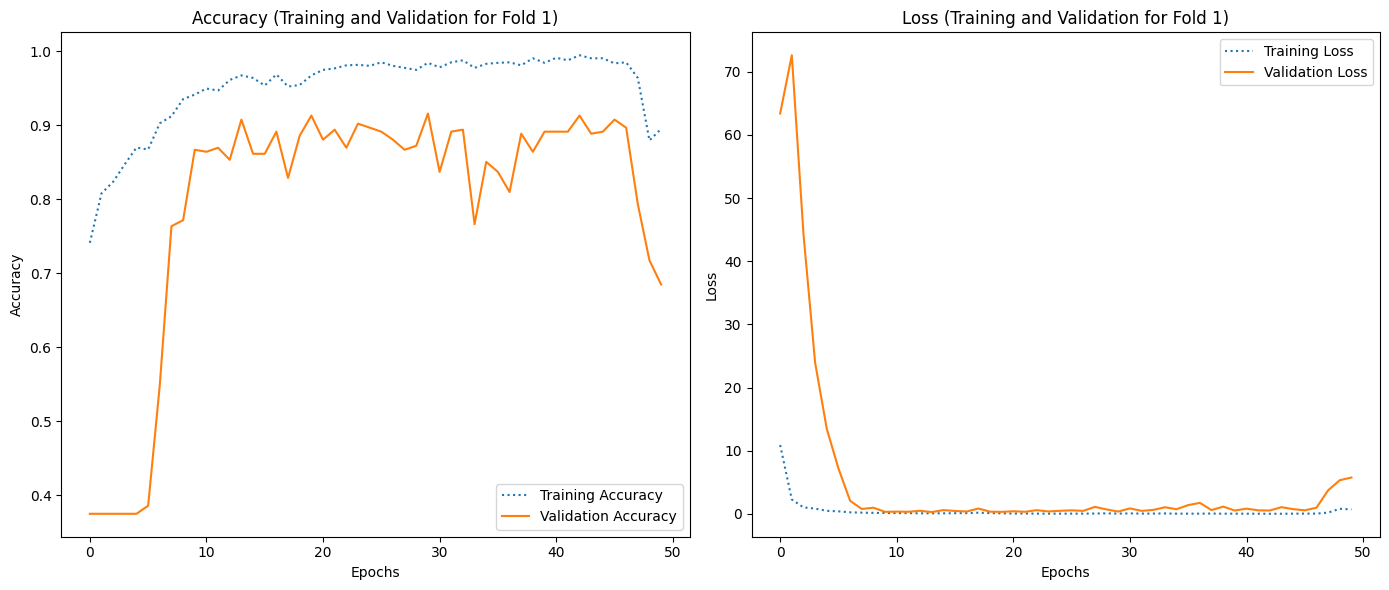

In [ ]:
import os
import matplotlib.pyplot as plt
import json

# Folder where checkpoints and history files are stored
checkpoints_folder = 'CNNModelHistory'

# Specify the fold number to plot
selected_fold = '1'  # Change this to the desired fold number (e.g., '2', '3', etc.)

# Dictionary to store metrics for the selected fold
fold_metrics = None

# Debug: List all files in the folder
print("Files in the checkpoints folder:")
print(os.listdir(checkpoints_folder))

# Find and load the history for the selected fold
checkpoint_files = [f for f in os.listdir(checkpoints_folder) if f.endswith('.keras')]
for checkpoint_file in checkpoint_files:
    # Extract fold number from the .keras file name
    fold_number = checkpoint_file.split('_')[1].replace('fold', '').replace('.keras', '')

    if fold_number == selected_fold:
        # Define the correct history file path
        history_filepath = os.path.join(
            checkpoints_folder,
            f'fold_{fold_number}_history.json'  # Matches the actual history file naming
        )

        # Debug: Print the derived history filepath
        print(f"Looking for history file: {history_filepath}")

        # Check if history file exists
        if os.path.exists(history_filepath):
            print(f"Found history file: {history_filepath}")
            with open(history_filepath, 'r') as f:
                history = json.load(f)

            # Store metrics for this fold
            fold_metrics = {
                'val_accuracy': history.get('val_accuracy', []),
                'val_loss': history.get('val_loss', []),
                'train_accuracy': history.get('accuracy', []),
                'train_loss': history.get('loss', [])
            }
        else:
            print(f"History file not found for checkpoint: {checkpoint_file}")

# Check if metrics for the selected fold were loaded
if fold_metrics is None:
    print(f"No data found for fold {selected_fold}")
else:
    # Plot Accuracy and Loss for the selected fold
    plt.figure(figsize=(14, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(fold_metrics['train_accuracy'], label='Training Accuracy', linestyle='dotted')
    plt.plot(fold_metrics['val_accuracy'], label='Validation Accuracy', linestyle='solid')
    plt.title(f'Accuracy (Training and Validation for Fold {selected_fold})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(fold_metrics['train_loss'], label='Training Loss', linestyle='dotted')
    plt.plot(fold_metrics['val_loss'], label='Validation Loss', linestyle='solid')
    plt.title(f'Loss (Training and Validation for Fold {selected_fold})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Evaluating on the Test Set (Confusion Matrix)

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


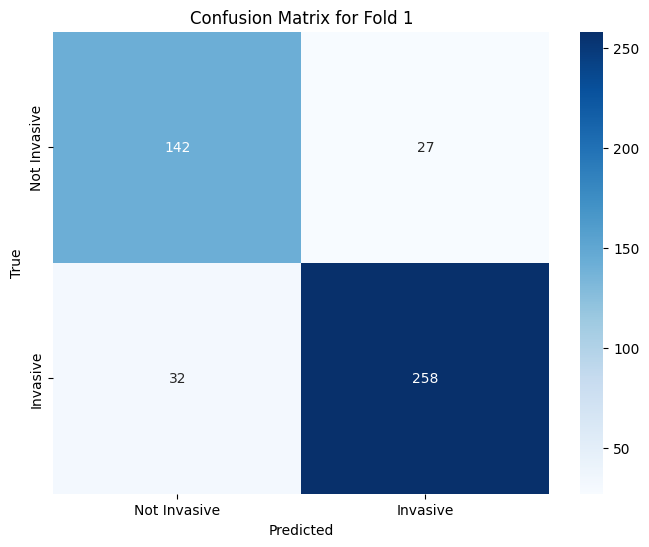

Classification Report for Fold 1:
              precision    recall  f1-score   support

Not Invasive       0.82      0.84      0.83       169
    Invasive       0.91      0.89      0.90       290

    accuracy                           0.87       459
   macro avg       0.86      0.86      0.86       459
weighted avg       0.87      0.87      0.87       459



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Function to load a specific fold model and evaluate on its validation set
def evaluate_fold_model(fold_number, X_test, y_test):
    # Load the model for the specific fold
    fold_model_path = f'CNNModelHistory/fold_{fold_number}_best_model.keras'  # Change to your correct model folder
    model = load_model(fold_model_path)

    # Predict on the test data
    batch_size = 8
    y_pred = model.predict(X_test, batch_size=batch_size)

    y_pred_classes = (y_pred > 0.5).astype(int)  # Binary classification

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Invasive', 'Invasive'], yticklabels=['Not Invasive', 'Invasive'])

    plt.title(f'Confusion Matrix for Fold {fold_number}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Classification Report
    report = classification_report(y_test, y_pred_classes, target_names=['Not Invasive', 'Invasive'])

    print(f"Classification Report for Fold {fold_number}:")
    print(report)

# Example usage:
# Choose a fold to evaluate (e.g., Fold 1)
selected_fold = 1  # Change this number to navigate different folds
# Ensure X_test and y_test are available for evaluation (from your dataset)
evaluate_fold_model(selected_fold, X_test, y_test)


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Metrics for Fold 1 computed.
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Metrics for Fold 2 computed.
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Metrics for Fold 3 computed.
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Metrics for Fold 4 computed.
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Metrics for Fold 5 computed.


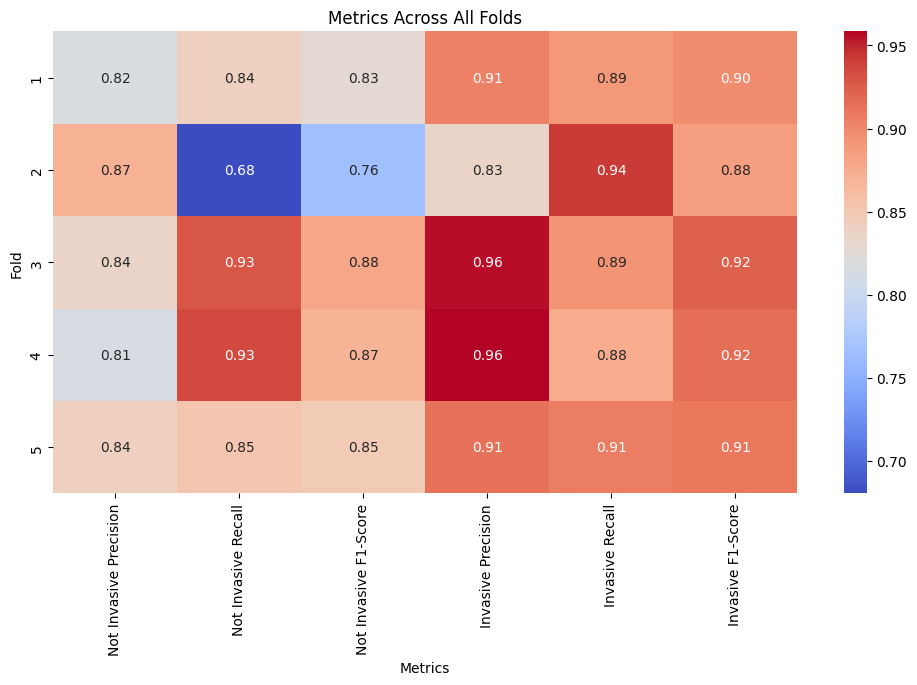

   Fold  Not Invasive Precision  Not Invasive Recall  Not Invasive F1-Score  \
0     1                0.816092             0.840237               0.827988   
1     2                0.871212             0.680473               0.764120   
2     3                0.835106             0.928994               0.879552   
3     4                0.814433             0.934911               0.870523   
4     5                0.842105             0.852071               0.847059   

   Invasive Precision  Invasive Recall  Invasive F1-Score  
0            0.905263         0.889655           0.897391  
1            0.834862         0.941379           0.884927  
2            0.955720         0.893103           0.923351  
3            0.958491         0.875862           0.915315  
4            0.913194         0.906897           0.910035  


In [ ]:
import pandas as pd

# Function to evaluate all folds and store metrics
def evaluate_all_folds(num_folds, X_test, y_test):
    metrics = []  # To store metrics for each fold

    for fold_number in range(1, num_folds + 1):
        # Load the model for the specific fold
        fold_model_path = f'CNNModelHistory/fold_{fold_number}_best_model.keras'  # Change to your correct model folder
        model = load_model(fold_model_path)

        # Predict on the test data
        batch_size = 8
        y_pred = model.predict(X_test, batch_size=batch_size)
        y_pred_classes = (y_pred > 0.5).astype(int)  # Binary classification

        # Classification Report
        report = classification_report(
            y_test, y_pred_classes, target_names=['Not Invasive', 'Invasive'], output_dict=True
        )

        # Extract recall, precision, and F1-score for each class
        metrics.append({
            "Fold": fold_number,
            "Not Invasive Precision": report['Not Invasive']['precision'],
            "Not Invasive Recall": report['Not Invasive']['recall'],
            "Not Invasive F1-Score": report['Not Invasive']['f1-score'],
            "Invasive Precision": report['Invasive']['precision'],
            "Invasive Recall": report['Invasive']['recall'],
            "Invasive F1-Score": report['Invasive']['f1-score'],
        })

        print(f"Metrics for Fold {fold_number} computed.")

    # Create a DataFrame for the results
    metrics_df = pd.DataFrame(metrics)

    # Plot the results
    plt.figure(figsize=(12, 6))
    sns.heatmap(metrics_df.iloc[:, 1:].set_index(metrics_df['Fold']), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Metrics Across All Folds')
    plt.xlabel('Metrics')
    plt.ylabel('Fold')
    plt.show()

    return metrics_df

# Example usage:
# Ensure X_test and y_test are available for evaluation (from your dataset)
num_folds = 5  # Replace with the actual number of folds in your experiment
metrics_df = evaluate_all_folds(num_folds, X_test, y_test)

# Display the DataFrame with metrics
print(metrics_df)


# Evaluate then Save them

29/29 [==============================] - 3s 74ms/step


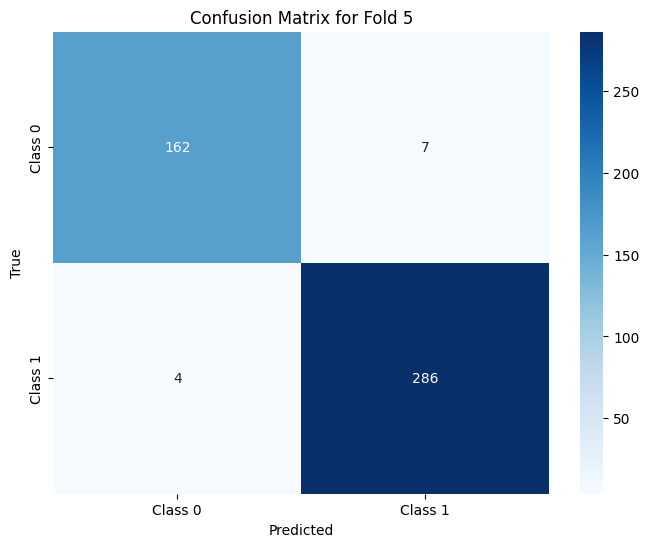

Classification Report for Fold 5:
              precision    recall  f1-score   support

     Class 0       0.98      0.96      0.97       169
     Class 1       0.98      0.99      0.98       290

    accuracy                           0.98       459
   macro avg       0.98      0.97      0.97       459
weighted avg       0.98      0.98      0.98       459

Model for Fold 5 saved at: saved_models/mobilenet_fold5.h5


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Function to load a specific fold model, evaluate on its validation set, and save it in .h5 format
def evaluate_and_save_fold_model(fold_number, X_test, y_test, save_folder='saved_models'):
    # Load the model for the specific fold
    fold_model_path = f'mobilenet2/mobilenet_fold{fold_number}.keras'  # Change folder and naming if necessary
    model = load_model(fold_model_path)

    # Predict on the validation data
    # Predict in smaller batches
    batch_size = 16  # Try a smaller batch size if the GPU is running out of memory
    y_pred = model.predict(X_test, batch_size=batch_size)

    y_pred_classes = (y_pred > 0.5).astype(int)  # Binary classification
    # For multi-class: y_pred_classes = np.argmax(y_pred, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    # Replace xticklabels and yticklabels with class names for multi-class problems
    plt.title(f'Confusion Matrix for Fold {fold_number}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Classification Report
    report = classification_report(y_test, y_pred_classes, target_names=['Not Invasive', 'Class 1'])
    # Replace target_names with class names for multi-class problems
    print(f"Classification Report for Fold {fold_number}:")
    print(report)

    # Save the model in .h5 format
    saved_model_path = f'{save_folder}/mobilenet_fold{fold_number}.h5'
    model.save(saved_model_path)
    print(f"Model for Fold {fold_number} saved at: {saved_model_path}")

# Example usage:
# Choose a fold to evaluate (e.g., Fold 1)
selected_fold = 5  # Change this number to navigate different folds
# Ensure X_test and y_test for the selected fold are available
evaluate_and_save_fold_model(selected_fold, X_test, y_test)


# Load the Model & Prediction Made

DEBUG:PIL.TiffImagePlugin:tag: XResolution (282) - type: rational (5) Tag Location: 22 - Data Location: 2158 - value: b'\x00\x00\x00\xf0\x00\x00\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: YResolution (283) - type: rational (5) Tag Location: 34 - Data Location: 2166 - value: b'\x00\x00\x00\xf0\x00\x00\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: ResolutionUnit (296) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: DateTime (306) - type: string (2) Tag Location: 58 - Data Location: 2174 - value: b'2017:03:28 21:24:13\x00'
DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x00\x00\x08\x92'
DEBUG:PIL.TiffImagePlugin:tag: GPSInfoIFD (34853) - type: long (4) - value: b'\x00\x00\x11B'
DEBUG:PIL.TiffImagePlugin:tag: unknown (59932) - type: undefined (7) Tag Location: 94 - Data Location: 98 - value: <table: 2060 bytes>


1/1 [==============================] - 1s 514ms/step
Predicted class: 0


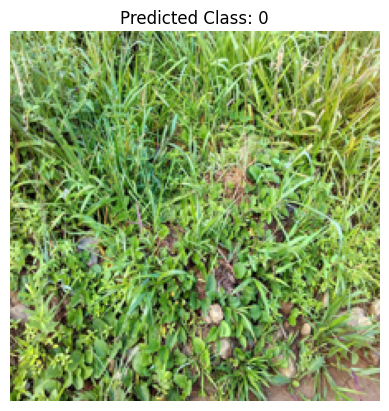

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Function to load the model and make a prediction on a single image
def load_model_and_predict(model_path, image_path):
    # Load the model
    model = load_model(model_path)

    # Load and preprocess the image
    img = Image.open(image_path)
    img = img.resize((224, 224))  # Resize image to match model input size (224x224 for MobileNet)
    img_array = np.array(img)  # Convert the image to a numpy array

    # Ensure the image has 3 channels (RGB)
    if img_array.shape[-1] == 1:  # If the image is grayscale, convert it to RGB
        img_array = np.repeat(img_array, 3, axis=-1)

    # Normalize the image (if required by the model, MobileNet for example requires normalization)
    img_array = img_array / 255.0  # Normalize the image pixel values to [0, 1]

    # Expand dimensions to match model input shape (1, 224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0)

    # Make a prediction
    y_pred = model.predict(img_array)

    # Convert the prediction to a binary class
    y_pred_class = (y_pred > 0.5).astype(int)

    # Output the prediction
    print(f"Predicted class: {y_pred_class[0][0]}")  # 0 or 1 for binary classification

    # Optionally, display the image
    plt.imshow(img)
    plt.title(f"Predicted Class: {y_pred_class[0][0]}")
    plt.axis('off')
    plt.show()

# Example usage:
# Provide the path to your saved model and image file
model_path = 'saved_models/mobilenet_fold3.h5'  # Update with the path to your model
image_path = 'invasive-species-monitoring/test/test/1000.jpg'  # Update with the path to the image you want to predict

# Load the model and predict the class for the image
load_model_and_predict(model_path, image_path)


# Test the Api

In [ ]:
import requests

url = "http://127.0.0.1:5000/predict"
file_path = "invasive-species-monitoring/test/test/1005.jpg"

# Send the request
response = requests.post(url, files={'file': open(file_path, 'rb')})

# Print the response
print(response.json())




{'predicted_class': 'Invasive'}


# Trials

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")


In [ ]:
curl.exe -X POST -F "file=@invasive-species-monitoring/test/test/1.jpg" http://127.0.0.1:5000/predict

SyntaxError: invalid syntax (3333133131.py, line 1)

# Test Accuracy

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np

def preprocess_image(image_path, target_size=(224, 224)):
    """
    Load and preprocess the image to the format expected by VGG16 model.
    """
    img = image.load_img(image_path, target_size=target_size)  # Resize image
    img_array = image.img_to_array(img)  # Convert image to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize the image
    return img_array

def predict_image(image_path, fold_number=0, checkpoints_folder='mobilenet'):
    """
    Load the trained model for a specific fold, preprocess the image, and make a prediction.
    """
    # Load the trained model from a specific fold
    model_filename = os.path.join(checkpoints_folder, f'mobilenet_fold{fold_number + 1}.keras')
    model = load_model(model_filename)

    # Preprocess the image
    img_array = preprocess_image(image_path)

    # Make prediction
    prediction = model.predict(img_array)

    # Return the predicted class
    if prediction >= 0.5:
        return "Class 1"  # If output is greater than or equal to 0.5, it's class 1
    else:
        return "Class 0"  # Otherwise, it's class 0

# Example usage
image_path = 'invasive-species-monitoring/test/test/1000.jpg'  # Path to the image you want to predict
predicted_class = predict_image(image_path, fold_number=0)  # Predict using fold 0
print(f"Predicted Class: {predicted_class}")


DEBUG:PIL.TiffImagePlugin:tag: XResolution (282) - type: rational (5) Tag Location: 22 - Data Location: 2158 - value: b'\x00\x00\x00\xf0\x00\x00\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: YResolution (283) - type: rational (5) Tag Location: 34 - Data Location: 2166 - value: b'\x00\x00\x00\xf0\x00\x00\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: ResolutionUnit (296) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: DateTime (306) - type: string (2) Tag Location: 58 - Data Location: 2174 - value: b'2017:03:28 21:24:13\x00'
DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x00\x00\x08\x92'
DEBUG:PIL.TiffImagePlugin:tag: GPSInfoIFD (34853) - type: long (4) - value: b'\x00\x00\x11B'
DEBUG:PIL.TiffImagePlugin:tag: unknown (59932) - type: undefined (7) Tag Location: 94 - Data Location: 98 - value: <table: 2060 bytes>


1/1 [==============================] - 1s 686ms/step
Predicted Class: Class 0


In [ ]:
from tensorflow.keras.models import load_model
import os

model_path = os.path.join('mobilenet2', 'mobilenet_fold1.keras')
print(f"Attempting to load model from: {model_path}")
model = load_model(model_path)
print("Model loaded successfully!")

Attempting to load model from: mobilenet2\mobilenet_fold1.keras
Model loaded successfully!


# Trials

In [ ]:
import os
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np

# File to track completed folds
completed_folds_file = 'completed_folds.txt'

# Folder to store checkpoints
checkpoints_folder = 'checkpoints'
os.makedirs(checkpoints_folder, exist_ok=True)

# File to log fold accuracies
fold_accuracies_file = os.path.join(checkpoints_folder, 'fold_accuracies.txt')

# Load completed folds if the file exists
if os.path.exists(completed_folds_file):
    with open(completed_folds_file, 'r') as f:
        completed_folds = set(map(int, f.read().splitlines()))
else:
    completed_folds = set()

from sklearn.model_selection import StratifiedKFold

# StratifiedKFold cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []

# Start loop for cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):  # Pass y to maintain label proportions
    if fold in completed_folds:
        print(f"Skipping Fold {fold + 1}, already completed.")
        continue  # Skip this fold

    print(f"Training on Fold {fold + 1}")

    # Split into training and validation data
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Data augmentation for training data
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Load the VGG16 model with pretrained weights
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the base layers to use as a feature extractor
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers for binary classification
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)  # Binary classification

    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    # Checkpoint file for the current fold
    checkpoint_filepath = os.path.join(checkpoints_folder, f'vgg16_fold{fold+1}.keras')

    # Load checkpoint if available
    if os.path.exists(checkpoint_filepath):
        model.load_weights(checkpoint_filepath)
        print(f"Resuming training for Fold {fold + 1} from checkpoint.")

    # Define checkpoint callback
    checkpoint_callback = ModelCheckpoint(
        checkpoint_filepath,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    # Train the model
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=32),  # Augmented training data
        validation_data=(X_val, y_val),                # Validation data (no augmentation)
        epochs=30,
        callbacks=[checkpoint_callback]
    )

    # Evaluate on the validation set
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"Fold {fold + 1} Accuracy: {val_accuracy:.4f}")
    fold_accuracies.append(val_accuracy)

    # Save fold completion to file
    with open(completed_folds_file, 'a') as f:
        f.write(f"{fold}\n")

    # Log accuracy to a file
    with open(fold_accuracies_file, 'a') as f:
        f.write(f"Fold {fold + 1} Accuracy: {val_accuracy:.4f}\n")

# Final results
average_accuracy = np.mean(fold_accuracies)
print(f"Average Accuracy across folds: {average_accuracy:.4f}")

# Append the average accuracy to the log file
with open(fold_accuracies_file, 'a') as f:
    f.write(f"Average Accuracy: {average_accuracy:.4f}\n")


Training on Fold 1
Epoch 1/30


ResourceExhaustedError: Graph execution error:

Detected at node 'model_11/block1_conv1/Relu' defined at (most recent call last):
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\M4tech\AppData\Local\Temp\ipykernel_1772\738850837.py", line 93, in <module>
      history = model.fit(
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model_11/block1_conv1/Relu'
OOM when allocating tensor with shape[32,224,224,64] and type half on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_11/block1_conv1/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_157212]

# Pytorch Code

In [ ]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to [N, C, H, W]
y_tensor = torch.tensor(y, dtype=torch.long)

# Define the dataset
dataset = TensorDataset(X_tensor, y_tensor)

# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# K-Fold Cross-Validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Directory to save models
checkpoints_folder = 'checkpoints'
os.makedirs(checkpoints_folder, exist_ok=True)

# Training settings
num_epochs = 10
batch_size = 32
learning_rate = 1e-4

fold_accuracies = []

In [ ]:
for fold, (train_idx, val_idx) in enumerate(kf.split(X_tensor)):
    print(f"Starting Fold {fold + 1}")

    # Subset the dataset for train and validation splits
    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)

    # Apply transforms
    train_dataset.dataset.tensors = (
        transform_train(train_dataset.dataset.tensors[0]),
        train_dataset.dataset.tensors[1],
    )
    val_dataset.dataset.tensors = (
        transform_val(val_dataset.dataset.tensors[0]),
        val_dataset.dataset.tensors[1],
    )

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Load pretrained VGG16 model
    model = models.vgg16(pretrained=True)
    for param in model.features.parameters():
        param.requires_grad = False  # Freeze feature extractor layers

    # Modify the classifier for your task
    num_classes = len(np.unique(y))  # Number of output classes
    model.classifier[6] = nn.Sequential(
        nn.Linear(4096, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, num_classes),
        nn.LogSoftmax(dim=1)  # For multi-class classification
    )
    model = model.to(device)

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

    # Train the model
    best_val_acc = 0.0
    checkpoint_path = os.path.join(checkpoints_folder, f'vgg16_fold{fold+1}.pth')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels)

        train_acc = correct_preds.double() / len(train_dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels)

        val_acc = val_corrects.double() / len(val_dataset)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {running_loss / len(train_loader):.4f}, "
              f"Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_acc:.4f}")

        # Save the model if validation accuracy improves
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), checkpoint_path)

    print(f"Fold {fold + 1} Best Validation Accuracy: {best_val_acc:.4f}")
    fold_accuracies.append(best_val_acc.item())

# Final results
average_accuracy = np.mean(fold_accuracies)
print(f"Average Accuracy across folds: {average_accuracy:.4f}")

Starting Fold 1


In [ ]:
from flask import Flask, request, render_template
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Initialize the Flask app
app = Flask(__name__)

# Load your pre-trained model
model_path = "saved_models/mobilenet_fold1.h5"  # Change this to your model's path
model = load_model(model_path)

# Define the target image size (the size your model expects)
IMAGE_SIZE = (224, 224)  # Update based on your model input size


@app.route("/", methods=["GET", "POST"])
def home():
    if request.method == "POST":
        # Check if the post request has the file part
        if "file" not in request.files:
            return "No file part in the request"
        file = request.files["file"]

        # If user does not select file, browser may submit an empty part without filename
        if file.filename == "":
            return "No file selected for uploading"

        if file:
            # Save the uploaded file to a temporary directory
            file_path = os.path.join("uploads", file.filename)
            os.makedirs("uploads", exist_ok=True)
            file.save(file_path)

            # Preprocess the image
            img = load_img(file_path, target_size=IMAGE_SIZE)
            img_array = img_to_array(img) / 255.0  # Normalize the image
            img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

            # Run prediction
            prediction = model.predict(img_array)
            print(prediction_class)
            prediction_class = "Invasive species detected!" if prediction > 0.5 else "No invasive species detected."

            # Remove the file after processing
            os.remove(file_path)

            return render_template("result.html", result=prediction_class)

    return render_template("index.html")


if __name__ == "__main__":
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

C:\Users\M4tech\anaconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
pip install flask tensorflow


  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
Using cached click-8.1.7-py3-none-any.whl (97 kB)
Note: you may need to restart the kernel to use updated packages.
